In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [3]:
from sklearn.cluster import KMeans

In [18]:
TRAIN_DIR_PATH = '../train/'

train_files = listdir(TRAIN_DIR_PATH)
#train_paths = np.array([TRAIN_DIR_PATH + f for f in train_files])
# observations = np.concatenate([np.genfromtxt(fname=f,usecols=[1,2,3,4,5,6]) for f in train_files],axis=0)

observations = []
obs_flabels = []
for f in train_files:
    obs = np.genfromtxt(fname=TRAIN_DIR_PATH + f, usecols=[1,2,3,4,5,6]) #read observations from file
    fname = np.full((obs.shape[0],1),f) #label observations with filename
    observations.append(obs)
    obs_flabels.append(fname)
observations = np.concatenate(observations) #convert observation vector to numpy array
observations.shape

#train_data = np.array([np.genfromtxt(fname=f)])

# train_wave_files = train_files[['wave' in x for x in train_files]]
# train_inf_files = train_files[['inf' in x for x in train_files]]
# train_eight_files = train_files[['eight' in x for x in train_files]]
# train_circle_files = train_files[['circle' in x for x in train_files]]
# train_beat3_files = train_files[['beat3' in x for x in train_files]]
# train_inf_files = train_files[['inf' in x for x in train_files]]

# train_inf_files

(79340, 6)

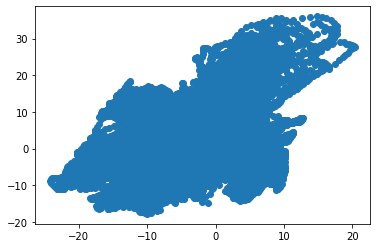

In [47]:
plt.scatter(observations[:,1],observations[:,2])

In [19]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=0).fit(observations)

In [44]:
#generate random probability matrix (rows sum to 1)
def rand_prob_mat(shape):
    p = np.zeros(shape)
    nrows = shape[0]
    ncols = shape[1]
    for i in range(nrows):
        p[i,:] = np.random.rand(1,ncols)
        p[i,:] = p[i,:]/np.sum(p[i,:])
    return p

In [114]:
def forward_filt(A, B, pi, obs):
    #q_ki = P(s_k = i, y_1:k)
    alpha = np.zeros((len(obs),len(A))) #n_obs x n_states

    #initialization
    o_k = obs[0] #scalar observation at time step k
    B_k = np.diag(B[:,o_k]) #4x4 diagonal matrix
    alpha[0] = np.dot(B_k,pi) #4x1 vector
    alpha[0] = alpha[0]/np.sum(alpha[0])
    for k in range(1,len(obs)):
        o_k = obs[k]
        B_k = np.diag(B[:,o_k])
        alpha[k] = np.dot(np.dot(B_k,A),alpha[k-1]) #alpha[k] = B_k * A * alpha[k-1]
        alpha[k] = alpha[k]/np.sum(alpha[k]) #normalize
    return alpha

In [119]:
def backward_filter(A, B, obs):
    K = len(obs)
    beta = np.zeros((K,len(A)))
    #initialization
    beta[K-1] = np.ones(len(A))
    for k in range(K-1,0,-1):
        o_k = obs[k]
        B_k = np.diag(B[:,o_k]) #diagonalize for elementwise multiplication w/ dot prod
        beta[k-1] = np.dot(np.dot(A,B_k),beta[k]) #beta[k-1] = A * B_k * beta[k]
        beta[k-1] = beta[k-1]/np.sum(beta[k-1])
    return beta


In [126]:
def smoother(alpha, beta):
    K = len(alpha) #number of observations/time steps
    gamma = np.zeros(alpha.shape)
    for k in range(K):
        alpha_k = alpha[k]
        beta_k = beta[k]
        num = np.multiply(alpha, beta_d)
        den = np.sum(num) #sum across all states
        gamma[k] = num/den 
    return gamma

## Simulate toy Markov Chain to test filters

In [97]:
np.random.seed(42)

#3 possible states, 5 possible observations
pi = [0.2, 0.6, 0.2]

# sj   0    1    2  | si
A = [[0.3, 0.3, 0.4], #0
     [0.8, 0.1, 0.1], #1
     [0.2, 0.3, 0.5]] #2
A = np.array(A)

# ok   0    1    2    3    4  | sk
B = [[0.50, 0.30, 0.10, 0.05, 0.05], #0
     [0.05, 0.20, 0.50, 0.20, 0.05], #1
     [0.05, 0.05, 0.10, 0.30, 0.50]] #s
B = np.array(B)

K = 30
s = np.zeros(K,dtype=np.uint8) #vector of samples
o = np.zeros(K,dtype=np.uint8) #vector of observations
s[0] = np.random.choice(len(A), 1, p=pi) #sim initial state
for k in range(1,K):
    s[k] = np.random.choice(len(A), 1, p=A[s[k-1]]) #sim next state
    o[k] = np.random.choice(B.shape[1], 1, p=B[s[k]]) #sim observation

In [ ]:
alpha = forward_filt(A, B, pi, o)
beta = backward_filter(A, B, o)


In [121]:
b = backward_filter(A, B, o)
b_ste = np.argmax(b,axis=1)

In [125]:
alpha = forward_filt(A, B, pi, o)
f_ste = np.argmax(alpha,axis=1)

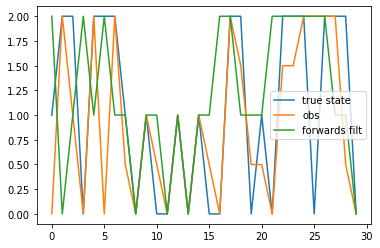

In [123]:
plt.plot(s)
plt.plot(o/2)
plt.plot(b_ste)
plt.legend(['true state', 'obs', 'forwards filt'])

In [113]:
mse_obs = np.mean(((s - o)**2))
mse_est = np.mean(((s - state_est)**2))
print('obs mse:\t', mse_obs)
print('filt mse:\t',mse_est)

obs mse:	 1.9666666666666666
filt mse:	 0.5333333333333333


In [49]:
np.random.seed(42)

#random transition and emission matrices
A = rand_prob_mat((4,4)) #Aij = P(s_k+1 = j | s_k = i)
B = rand_prob_mat((4,10)) #Bso = P(o_k = o | s_k = s)